# 1. Imporths

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score, roc_auc_score



<br>

# 2. Data


In [3]:
df = pd.read_csv("data/train.csv").drop('id',axis=1)

In [44]:
df.shape

(370789, 11)

In [47]:
df[df['Annual_Premium']!= 2630]['Response'].mean()

0.11980569575564215

In [46]:
df[df['Annual_Premium']== 2630]['Response'].mean()

0.1310942244555081

In [43]:
df['Annual_Premium'].value_counts().sort_values()

Annual_Premium
20706.0        1
53680.0        1
18264.0        1
59015.0        1
51104.0        1
           ...  
43707.0       36
45179.0       38
38287.0       38
39008.0       41
2630.0     64877
Name: count, Length: 41667, dtype: int64

In [20]:
Q1 = df['Annual_Premium'].quantile(0.25)
Q3 = df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df = df[(df['Annual_Premium'] >= limite_inferior) & (df['Annual_Premium'] <= limite_superior)]


In [21]:
df_sem_outliers.shape

(370789, 11)

In [22]:
381109-370789

10320

In [23]:
df.shape

(370789, 11)

In [24]:
df_sem_outliers['Response'].mean()

0.12178085110399715

In [25]:
df['Response'].mean()

0.12178085110399715

In [26]:
X = df.drop('Response',axis=1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

<br>

# 3. Data Quality

In [27]:
df_1 = pd.concat([X_train,y_train],axis=1)

### 3.1 Data Dimension

In [28]:
df_1.shape

(278091, 11)

### 3.2 Attributes Types

In [29]:
num_attributes = df_1.select_dtypes(include=['int64','float64']).columns.drop(['Driving_License','Previously_Insured'])
cat_attributes = df_1.columns.difference(num_attributes)


print("Numerical Attributes:\n", num_attributes)
print("\n")
print("Categorical Attributes:\n", cat_attributes)

Numerical Attributes:
 Index(['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel',
       'Vintage', 'Response'],
      dtype='object')


Categorical Attributes:
 Index(['Driving_License', 'Gender', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage'],
      dtype='object')


In [30]:


# Count null
null = df_1.isnull().sum().rename('count null')

# Percentage of null
pct_null = ((100*(df_1.isnull().sum()/len(df_1)).round(4)).astype('str')+'%').rename('pct null')

# Attributes Types
types= df_1.dtypes.rename('type')

nunique = df_1.nunique().rename('nunique')

# Distinct categorical values
cat_values = pd.Series(
    [df_1[col].unique() if col in cat_attributes else None for col in df_1.columns],
    index=df_1.columns,
    name='cat_values'
)

pd.concat([null, pct_null, types, cat_values,nunique], axis=1)

,count null,pct null,type,cat_values,nunique
Gender,0,0.0%,object,"[Male, Female]",2
Age,0,0.0%,int64,None,66
Driving_License,0,0.0%,int64,"[1, 0]",2
Region_Code,0,0.0%,float64,None,53
Previously_Insured,0,0.0%,int64,"[0, 1]",2
Vehicle_Age,0,0.0%,object,"[1-2 Year, < 1 Year, > 2 Years]",3
Vehicle_Damage,0,0.0%,object,"[Yes, No]",2
Annual_Premium,0,0.0%,float64,None,39947
Policy_Sales_Channel,0,0.0%,float64,None,152
Vintage,0,0.0%,int64,None,290


<br>

In [31]:
df['Region_Code'].value_counts().index

Index([28.0,  8.0, 46.0, 41.0, 15.0, 30.0, 29.0, 50.0,  3.0, 11.0, 36.0, 33.0,
       47.0, 35.0,  6.0, 45.0, 37.0, 18.0, 48.0, 14.0, 39.0, 10.0, 21.0,  2.0,
       13.0, 12.0,  7.0,  9.0, 27.0, 32.0, 43.0, 26.0, 17.0, 25.0, 24.0,  0.0,
       38.0, 16.0, 31.0, 23.0, 20.0, 49.0,  4.0, 34.0, 19.0, 22.0, 40.0,  5.0,
        1.0, 44.0, 42.0, 52.0, 51.0],
      dtype='float64', name='Region_Code')

<BarContainer object of 53 artists>

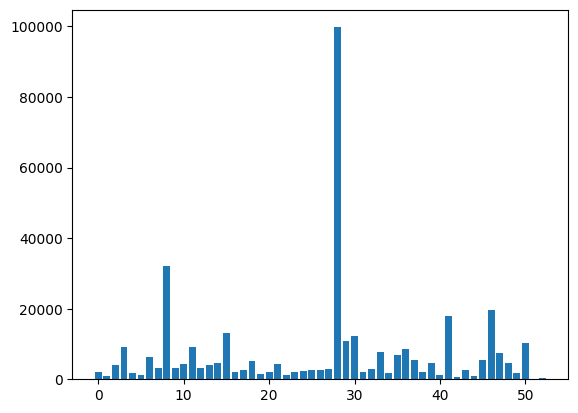

In [32]:
plt.bar(x =df['Region_Code'].value_counts().index ,height=df['Region_Code'].value_counts().values)

# 4. Data Cleaning

In [33]:
df_2 = df_1.copy()

### 4.1 Inconsistent Data Types

In [34]:
df_2[['Previously_Insured','Driving_License']] = df_2[['Previously_Insured','Driving_License']].astype('object')
df_2.dtypes

Gender                   object
Age                       int64
Driving_License          object
Region_Code             float64
Previously_Insured       object
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

<br>

# 5. Exploratory Data Analysis

In [35]:
df_3 = df_2.copy()

In [36]:
num_attributes = df_3.select_dtypes(include=['int64','float64']).columns
cat_attributes = df_3.select_dtypes(exclude=['int64','float64']).columns

### 5.1 Univariate Analysis

In [37]:
# Skew
skew = pd.DataFrame(df_3[num_attributes].apply( lambda x: x.skew() ) ,columns=['Skew']).T

# Kurtosis
kurtosis = pd.DataFrame(df_3[num_attributes].apply( lambda x: x.kurtosis() ),columns=['Kurtosis']).T

pd.concat([df_3[num_attributes].describe(),skew,kurtosis])

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,278091.000000,278091.000000,278091.000000,278091.000000,278091.000000,278091.000000
mean,38.686858,26.436134,29274.949283,112.560291,154.369196,0.121780
std,15.442831,13.308346,14738.212627,54.017191,83.697529,0.327032
min,20.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,15.000000,24102.000000,30.000000,82.000000,0.000000
50%,36.000000,28.000000,31315.000000,151.000000,154.000000,0.000000
75%,49.000000,36.000000,38612.000000,152.000000,227.000000,0.000000
max,85.000000,52.000000,61892.000000,163.000000,299.000000,1.000000
Skew,0.681819,-0.113541,-0.520288,-0.921297,0.002107,2.313058
Kurtosis,-0.545002,-0.888329,-0.332315,-0.929152,-1.200621,3.350259


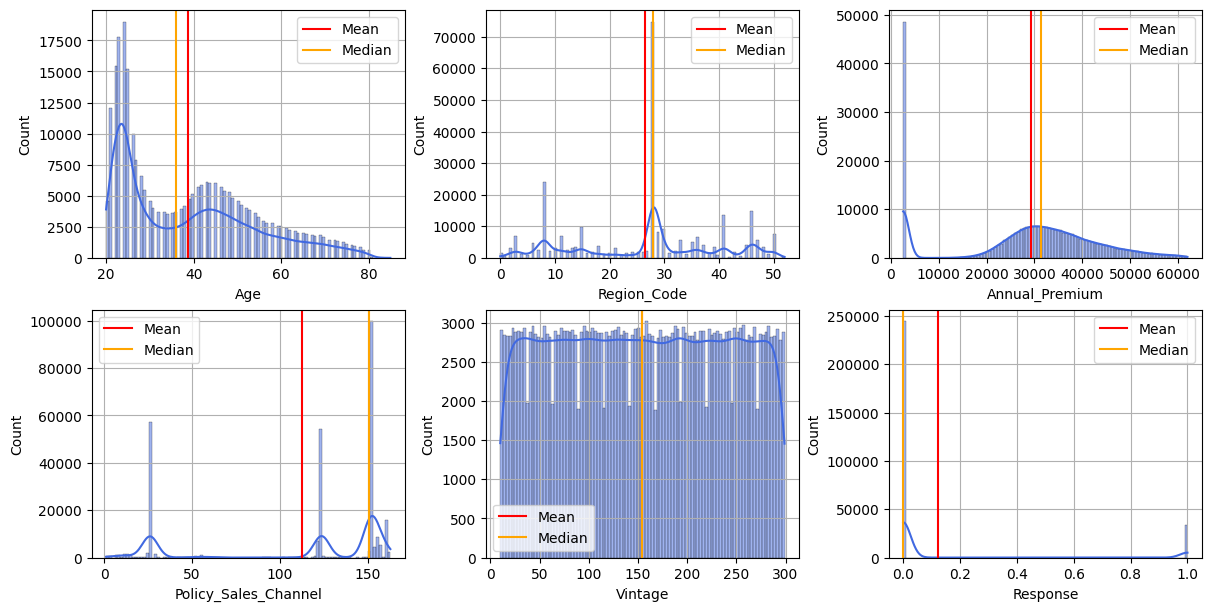

In [38]:
bins = 100
kde = True


# Graph Size
# Matrix of 3 columns and n rows
count_num = df_3[num_attributes].shape[1]
plot_cols_num = 3
plot_rows_num = math.ceil(count_num / plot_cols_num)

fig_num, axes_num = plt.subplots(
    nrows=plot_rows_num,
    ncols=plot_cols_num,
    figsize=(4 * plot_cols_num, 3 * plot_rows_num),
    constrained_layout=True
)

# Transform the axes into a 1D-Array to make them easier to manipulate.
axes_num = axes_num.flatten()

for i, col in enumerate(num_attributes):   
    # Distribution Chart
    sns.histplot(data=df_3.dropna(),
                 x=col,
                 bins=bins, kde=kde,
                 ax=axes_num[i],
                 color='royalblue',
                 edgecolor='black')

    # Mean
    mean = df_3[col].mean()
    axes_num[i].axvline(x=mean, color='red', label='Mean')
    
    # Median
    median = df_3[col].median()
    axes_num[i].axvline(x=median, color='orange', label='Median')
    
    axes_num[i].grid(True)
    axes_num[i].legend()

# Remove blank axes
for j in range(i + 1, len(axes_num)):
    fig_num.delaxes(axes_num[j])
plt.show()

##### Age

<Axes: ylabel='Age'>

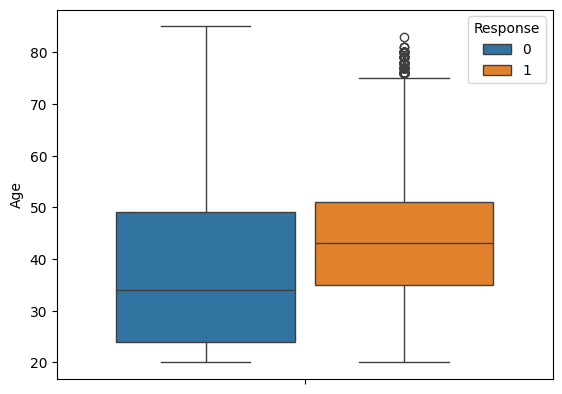

In [18]:
sns.boxplot(data=df_3,hue='Response',y='Age',gap=0.1)

##### Region Code

<Axes: ylabel='Region_Code'>

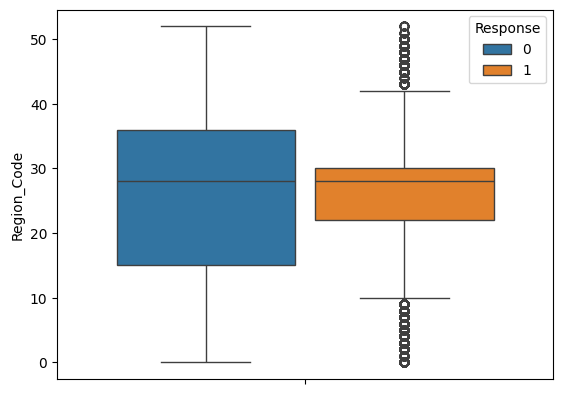

In [19]:
sns.boxplot(data=df_3,hue='Response',y='Region_Code',gap=0.1)

##### Annual_Premium

<Axes: ylabel='Annual_Premium'>

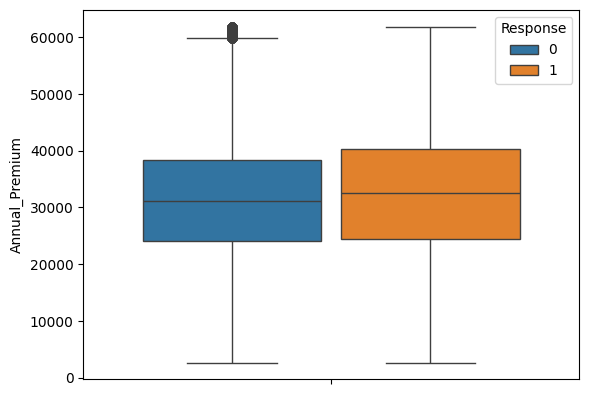

In [48]:
sns.boxplot(data=df_3,hue='Response',y='Annual_Premium',gap=0.1)

##### Policy_Sales_Channel

<Axes: ylabel='Policy_Sales_Channel'>

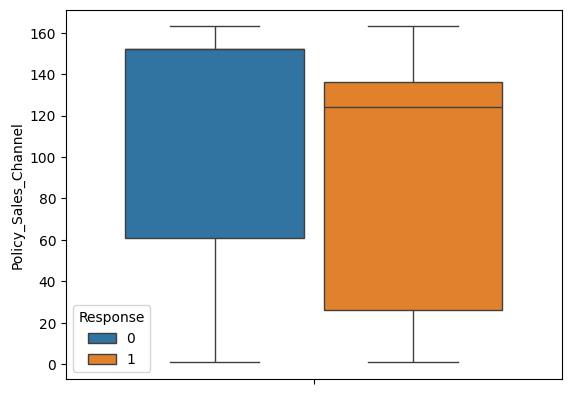

In [21]:
sns.boxplot(data=df_3,hue='Response',y='Policy_Sales_Channel',gap=0.1)

##### Vintage

<Axes: ylabel='Vintage'>

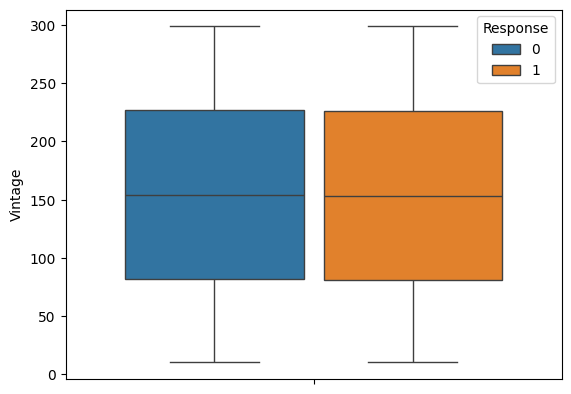

In [22]:
sns.boxplot(data=df_3,hue='Response',y='Vintage',gap=0.1)

### 5.2 Bivariate Analysis

##### Numerical Attributes

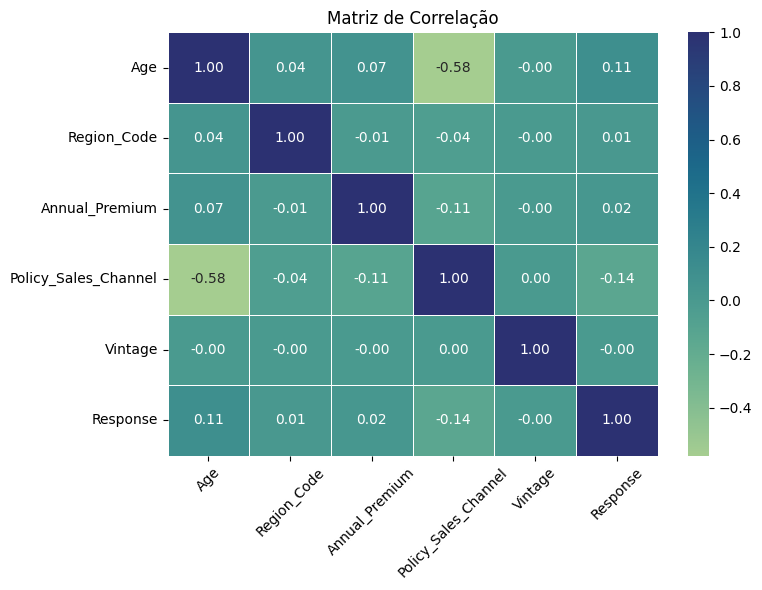

In [23]:
corr_matrix = df_3[num_attributes].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='crest', linewidths=0.5)
plt.xticks(rotation=45)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

##### Categorical Attributes


🔸 Tabela de contingência: Gender x Driving_License
Driving_License         0         1
Gender                             
Female           0.001280  0.998720
Male             0.002925  0.997075
All              0.002169  0.997831


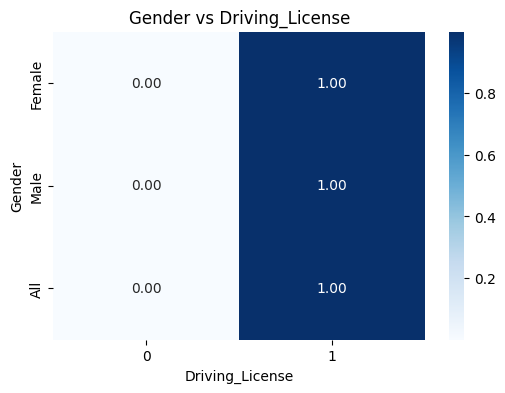


🔸 Tabela de contingência: Gender x Previously_Insured
Previously_Insured         0         1
Gender                                
Female              0.497559  0.502441
Male                0.580038  0.419962
All                 0.542153  0.457847


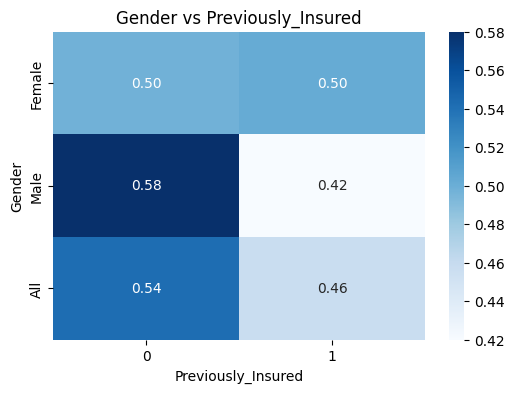


🔸 Tabela de contingência: Gender x Vehicle_Age
Vehicle_Age  1-2 Year  < 1 Year  > 2 Years
Gender                                    
Female       0.445796  0.521749   0.032455
Male         0.593387  0.356976   0.049638
All          0.525594  0.432661   0.041745


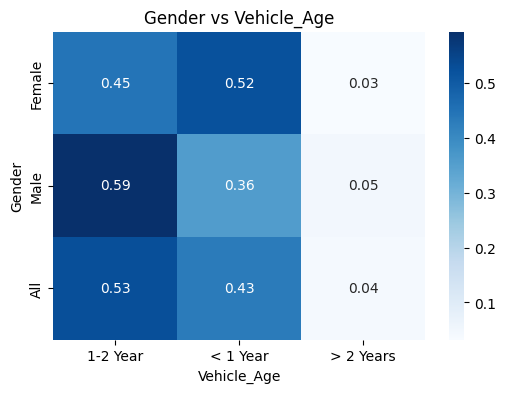


🔸 Tabela de contingência: Gender x Vehicle_Damage
Vehicle_Damage        No       Yes
Gender                            
Female          0.545186  0.454814
Male            0.452252  0.547748
All             0.494939  0.505061


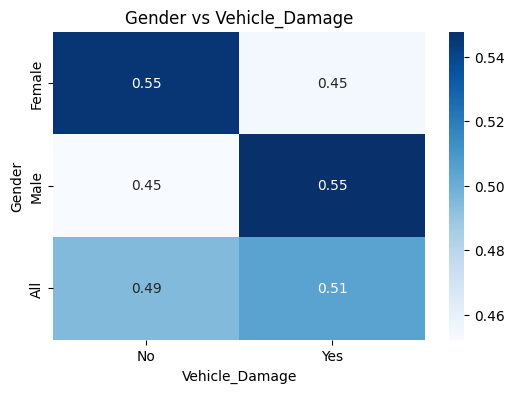


🔸 Tabela de contingência: Driving_License x Previously_Insured
Previously_Insured         0         1
Driving_License                       
0                   0.708065  0.291935
1                   0.541792  0.458208
All                 0.542153  0.457847


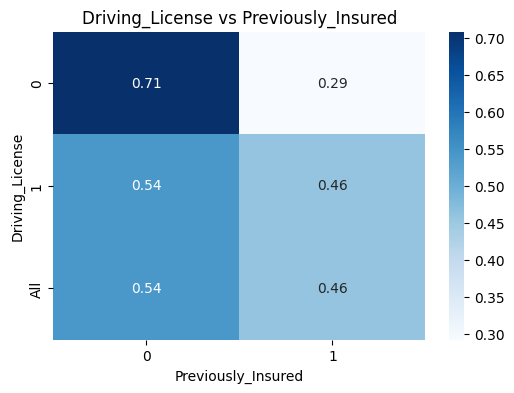


🔸 Tabela de contingência: Driving_License x Vehicle_Age
Vehicle_Age      1-2 Year  < 1 Year  > 2 Years
Driving_License                               
0                0.935484  0.001613   0.062903
1                0.524703  0.433598   0.041699
All              0.525594  0.432661   0.041745


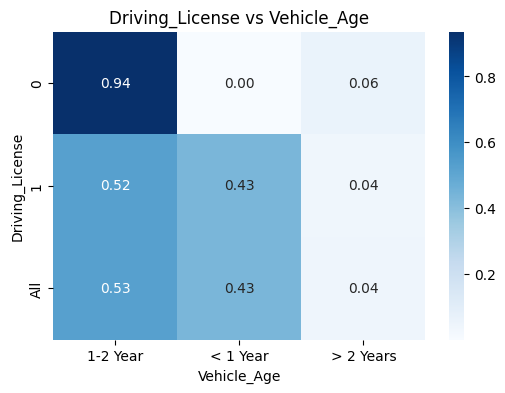


🔸 Tabela de contingência: Driving_License x Vehicle_Damage
Vehicle_Damage         No       Yes
Driving_License                    
0                0.319355  0.680645
1                0.495321  0.504679
All              0.494939  0.505061


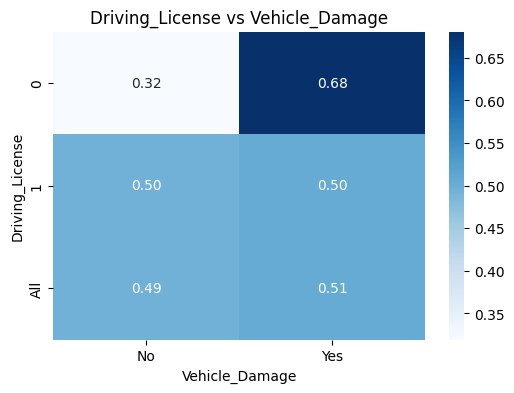


🔸 Tabela de contingência: Previously_Insured x Vehicle_Age
Vehicle_Age         1-2 Year  < 1 Year  > 2 Years
Previously_Insured                               
0                   0.654571  0.268669   0.076760
1                   0.372867  0.626850   0.000283
All                 0.525594  0.432661   0.041745


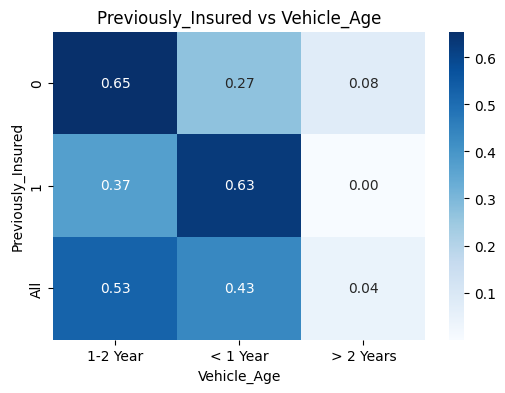


🔸 Tabela de contingência: Previously_Insured x Vehicle_Damage
Vehicle_Damage            No       Yes
Previously_Insured                    
0                   0.116776  0.883224
1                   0.942736  0.057264
All                 0.494939  0.505061


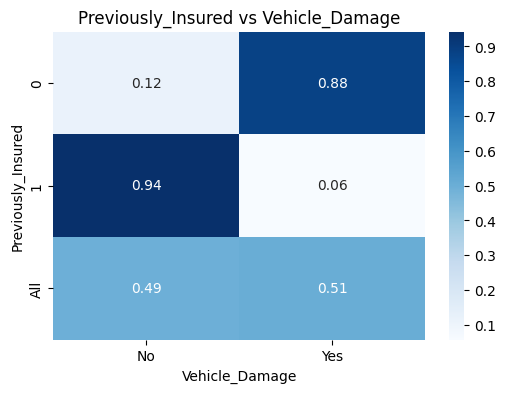


🔸 Tabela de contingência: Vehicle_Age x Vehicle_Damage
Vehicle_Damage        No       Yes
Vehicle_Age                       
1-2 Year        0.359054  0.640946
< 1 Year        0.707661  0.292339
> 2 Years       0.001090  0.998910
All             0.494939  0.505061


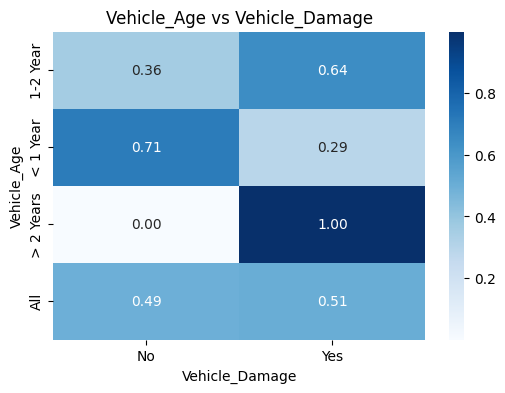

In [24]:
normalize = 'index'
for col1, col2 in combinations(cat_attributes, 2):
    print(f"\n🔸 Tabela de contingência: {col1} x {col2}")
    tabela = pd.crosstab(df_3[col1], df_3[col2], normalize=normalize, margins=True)      
    print(tabela)

    plt.figure(figsize=(6, 4))
    sns.heatmap(tabela, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f'{col1} vs {col2}')
    plt.show()

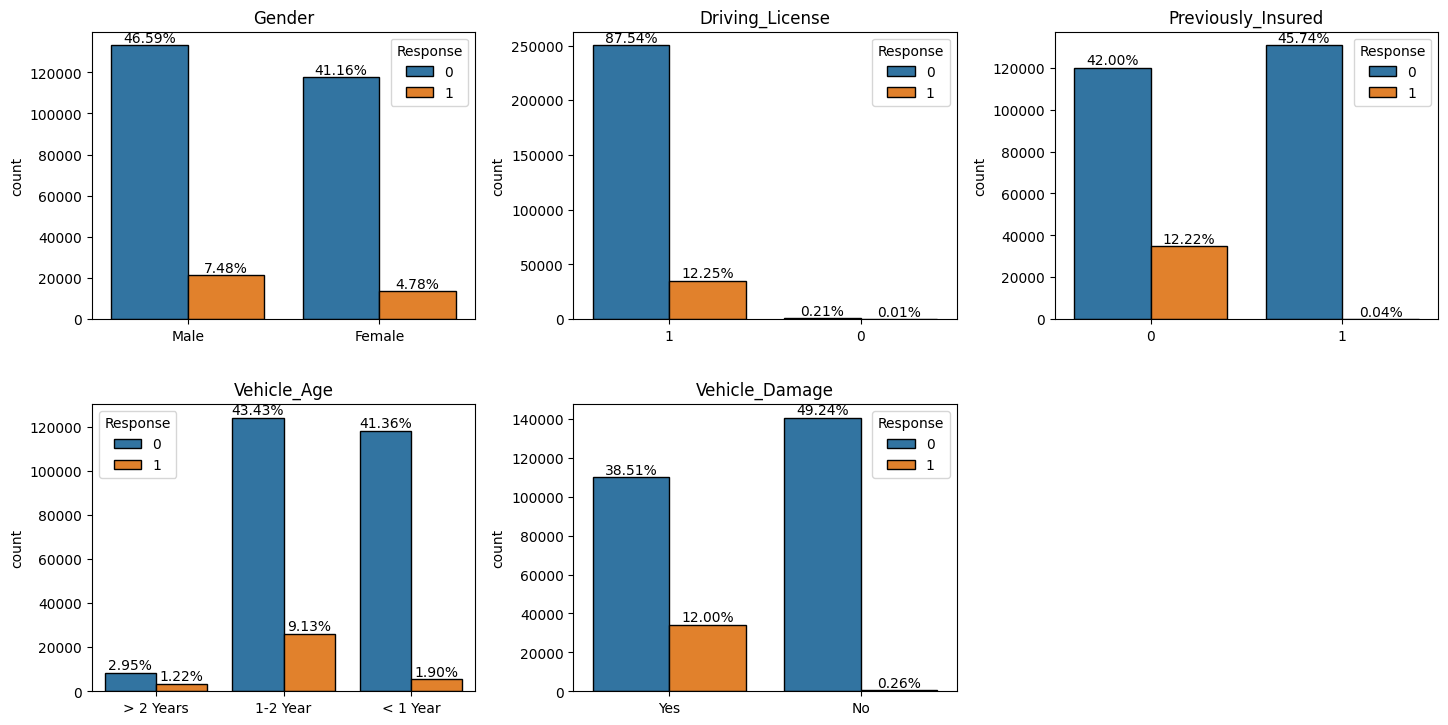

In [25]:
# Graph Size
# Matrix of 3 columns and n rows
count_cat = df_3[cat_attributes].shape[1]
plot_cols_cat = 3
plot_rows_cat = math.ceil(count_cat / plot_cols_cat)

fig_cat, axes_cat = plt.subplots(
    nrows=plot_rows_cat,
    ncols=plot_cols_cat,
    figsize=(5 * plot_cols_cat, 4 * plot_rows_cat)
)
fig_cat.tight_layout(pad=4.0)

# Transform the axes into a 1D-Array to make them easier to manipulate.
axes_cat = axes_cat.flatten()

for i, col in enumerate(cat_attributes):
    # Sort the columns
    order = list(df_3[col].infer_objects().fillna('nulos').unique())
    
    if 'nulos' in order:
        order.remove('nulos')
        order.append('nulos')

        
    palette = ['royalblue'] * (len(order) - 1) + ['red']
    ax = sns.countplot(data=df_3.infer_objects().fillna('nulos'),
                       ax=axes_cat[i],
                       x=col,
                       hue='Response',
                       edgecolor='black',
                       order=order)
    
    # Extract the frequency of each categorical attribute
    for container in ax.containers:            
        labels = [f'{(v.get_height()/len(df_3))*100:.2f}%' for v in container]
        ax.bar_label(container, labels=labels)    
 
    axes_cat[i].set_title(col)
    axes_cat[i].set_xlabel(None)
   


# Remove blank axes
for j in range(i + 1, len(axes_cat)):
    fig_cat.delaxes(axes_cat[j])

plt.show()

<br>

<br>

# 6. Data Processing

In [26]:
df_4 = df_3.copy()

In [27]:
X_train = df_4.drop('Response',axis=1)
y_train = df_4['Response']

In [28]:
X_train.shape

(285831, 10)

In [29]:
type(y_train.head())

pandas.core.series.Series

In [30]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
47542,Male,53,1,28.0,0,> 2 Years,Yes,40125.0,124.0,27
147062,Male,49,1,28.0,0,> 2 Years,Yes,57049.0,26.0,283
182323,Female,37,1,28.0,0,1-2 Year,No,33853.0,23.0,101
369893,Female,44,1,28.0,0,1-2 Year,Yes,30632.0,26.0,221
377376,Male,37,1,14.0,0,1-2 Year,Yes,32459.0,124.0,271


In [31]:
X_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
47542,Male,53,1,28.0,0,> 2 Years,Yes,40125.0,124.0,27
147062,Male,49,1,28.0,0,> 2 Years,Yes,57049.0,26.0,283
182323,Female,37,1,28.0,0,1-2 Year,No,33853.0,23.0,101
369893,Female,44,1,28.0,0,1-2 Year,Yes,30632.0,26.0,221
377376,Male,37,1,14.0,0,1-2 Year,Yes,32459.0,124.0,271
...,...,...,...,...,...,...,...,...,...,...
86745,Male,77,1,41.0,0,1-2 Year,No,45429.0,26.0,54
255619,Female,32,1,41.0,1,1-2 Year,No,32012.0,122.0,26
369946,Male,23,1,8.0,1,< 1 Year,No,31316.0,152.0,139
41621,Female,24,1,28.0,1,< 1 Year,No,46578.0,152.0,204


In [20]:
one_hot_cols = ['Gender','Vehicle_Age','Vehicle_Damage']
min_max_cols = ['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']

numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, min_max_cols),
    ('cat', categorical_transformer, one_hot_cols)
], remainder='passthrough')

pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100)))
])



In [21]:
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

<br>

<br>

# 7. Cross-Validation

Decision Tree  
Random Forest   
Logistict Regression  
Gradient Boosting Classifier   
SVM   
KNN


In [35]:
models = {
    'Decision Tree':DecisionTreeClassifier(random_state =42),
    'Random Forest':RandomForestClassifier(random_state =42),
    'Logistic Regression':LogisticRegression(random_state =42),
    'Gradient Boosting':GradientBoostingClassifier(random_state =42),
    'KNN':KNeighborsClassifier()
}

pipelines = {}
for name,model in models.items():
    pipelines[name] = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
        ('classifier', model)
    ])

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_auc = {}
for name, pipe in pipelines.items():
    scores_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc')

    auc = f'{scores_auc.mean():.3f} ± {scores_auc.std():.3f}'

    print(f'Modelo {name} - AUC médio: {scores_auc.mean():.3f} - Std: {scores_auc.std():.3f}')
    print('\n')
    
    
    
    scores = [
        auc
    ]
    metrics_auc[name] = scores
    
val_auc = pd.DataFrame(metrics_auc,index=['AUC']).T

Modelo Decision Tree - AUC médio: 0.625 - Std: 0.003


Modelo Random Forest - AUC médio: 0.808 - Std: 0.002


Modelo Logistic Regression - AUC médio: 0.802 - Std: 0.008


Modelo Gradient Boosting - AUC médio: 0.839 - Std: 0.003


Modelo KNN - AUC médio: 0.788 - Std: 0.003




In [39]:
val_auc

,AUC
Decision Tree,0.625 ± 0.003
Random Forest,0.808 ± 0.002
Logistic Regression,0.802 ± 0.008
Gradient Boosting,0.839 ± 0.003
KNN,0.788 ± 0.003


In [40]:
# NOVO
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = {}
for name, pipe in pipelines.items():
    scores_recall = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='recall')
    scores_precision = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='precision')
    scores_f1 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='f1')

    recall = f'{scores_recall.mean():.3f} ± {scores_recall.std():.3f}'
    precision = f'{scores_precision.mean():.3f} ± {scores_precision.std():.3f}'
    f1 = f'{scores_f1.mean():.3f} ± {scores_f1.std():.3f}'

    print(f'Modelo {name} - Recall médio: {scores_recall.mean():.3f} - Std: {scores_recall.std():.3f}')
    print(f'Modelo {name} - Recall médio: {scores_precision.mean():.3f} - Std: {scores_precision.std():.3f}')
    print(f'Modelo {name} - Recall médio: {scores_f1.mean():.3f} - Std: {scores_f1.std():.3f}')
    print('\n')
    
    
    
    scores = [
        recall,
        precision,
        f1
    ]
    metrics[name] = scores

val = pd.DataFrame(metrics,index=['Recall','Precision','F1']).T
    

Modelo Decision Tree - Recall médio: 0.362 - Std: 0.006
Modelo Decision Tree - Recall médio: 0.276 - Std: 0.003
Modelo Decision Tree - Recall médio: 0.313 - Std: 0.004


Modelo Random Forest - Recall médio: 0.436 - Std: 0.004
Modelo Random Forest - Recall médio: 0.298 - Std: 0.002
Modelo Random Forest - Recall médio: 0.356 - Std: 0.004


Modelo Logistic Regression - Recall médio: 0.977 - Std: 0.002
Modelo Logistic Regression - Recall médio: 0.250 - Std: 0.001
Modelo Logistic Regression - Recall médio: 0.398 - Std: 0.001


Modelo Gradient Boosting - Recall médio: 0.872 - Std: 0.004
Modelo Gradient Boosting - Recall médio: 0.286 - Std: 0.004
Modelo Gradient Boosting - Recall médio: 0.431 - Std: 0.004


Modelo KNN - Recall médio: 0.621 - Std: 0.003
Modelo KNN - Recall médio: 0.273 - Std: 0.002
Modelo KNN - Recall médio: 0.380 - Std: 0.002




In [42]:
val

,Recall,Precision,F1
Decision Tree,0.362 ± 0.006,0.276 ± 0.003,0.313 ± 0.004
Random Forest,0.436 ± 0.004,0.298 ± 0.002,0.356 ± 0.004
Logistic Regression,0.977 ± 0.002,0.250 ± 0.001,0.398 ± 0.001
Gradient Boosting,0.872 ± 0.004,0.286 ± 0.004,0.431 ± 0.004
KNN,0.621 ± 0.003,0.273 ± 0.002,0.380 ± 0.002


In [38]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def precision_recall_at_k(y_true, y_scores, k=0.1):
    """Calcula precision e recall nos top k% com maiores scores"""
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]  # índices dos top k%

    y_pred_at_k = np.zeros_like(y_true)
    y_pred_at_k[idx] = 1  # marca como positivo só os top k%

    precision = precision_score(y_true, y_pred_at_k)
    recall = recall_score(y_true, y_pred_at_k)
    return precision, recall


In [39]:


k_percent = 0.10  # top 10%
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

metrics_at_k = {}

for name, pipe in pipelines.items():
    
    precisions = []
    recalls = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_skf, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_skf, y_val = y[train_idx], y[val_idx]
        
        # Treine seu pipeline com SMOTE e o modelo clf
        pipeline = pipelines[name]
        pipeline.fit(X_train_skf, y_train_skf)
        
        # Pegue as probabilidades da classe 1
        y_proba = pipeline.predict_proba(X_val)[:, 1]
        
        # Calcule precision@k e recall@k
        p_k, r_k = precision_recall_at_k(y_val, y_proba, k=k_percent)
        precisions.append(p_k)
        recalls.append(r_k)

    recall_at_k = np.array(recalls)
    precision_at_k = np.array(precisions)

    recall = f'{recall_at_k.mean():.3f} ± {recall_at_k.std():.3f}'
    precision = f'{precision_at_k.mean():.3f} ± {precision_at_k.std():.3f}'

    metrics_at_k[name] = [recall,precision]

val_at_k = pd.DataFrame(metrics_at_k,index=[f'Recall_at_{k_percent*100:.0f}%',f'Precision_at_{k_percent*100:.0f}%']).T
    

In [40]:
val_at_k

,Recall_at_10%,Precision_at_10%
Decision Tree,0.100 ± 0.003,0.123 ± 0.003
Random Forest,0.098 ± 0.002,0.121 ± 0.002
Logistic Regression,0.098 ± 0.001,0.120 ± 0.001
Gradient Boosting,0.101 ± 0.002,0.124 ± 0.002
KNN,0.099 ± 0.004,0.121 ± 0.005


# 8. Grid-Search

In [36]:
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__max_depth': [1,2,3,4],
}


In [37]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_gb = GridSearchCV(
    estimator=pipelines['Gradient Boosting'],
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\joao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'Region_Code',
                                                                          'Annual_Premium',
                                                                          'Policy_Sales_Channel',
                                                                          'Vintage']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='firs...
                                       ('smote', SMOTE(random_state=42)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier())),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05],
                         'classifier__max_depth': [1, 2, 3, 4],
                         'classifier__n_estimators': [100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [44]:
params = {
    x.split('__')[1]:v for x,v in grid_gb.best_params_.items()
}

In [45]:
params

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}

<br>

# 9.Model

In [5]:
with open('pipeline.pkl', 'rb') as f:
    pipeline_processor = pickle.load(f)

In [6]:
params = {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}

In [7]:
pipeline_model = pipeline_processor.steps + [('model', GradientBoostingClassifier(**params, random_state=42))]

# Crie uma nova pipeline com esses steps
pipeline = ImbPipeline(pipeline_model)

In [8]:
print([name for name, step in pipeline_processor.steps])


['preprocess', 'smote', 'feature_selection']


In [9]:
pipeline.fit(X_train,y_train)

C:\Users\joao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Region_Code',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=2,
                                            n_estimators=200,
                                            random_state=42))])

In [10]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

recall_train = recall_score(y_train,y_train_pred)
recall_test = recall_score(y_test,y_test_pred)
precision_train = precision_score(y_train,y_train_pred)
precision_test = precision_score(y_test,y_test_pred)

print(f'Train Precision:{precision_train}')
print(f'Test Precision{precision_test}\n')
print(f'Train Recall{recall_train}')
print(f'Test Recall{recall_test}')

Train Precision:0.2797189059835165
Test Precision0.2798254251270724

Train Recall0.8942110070792418
Test Recall0.9004110292858366


In [ ]:
27.128 -> False positive
1.138 -> False negative
56.472 -> True negative
10.540 -> True positive

In [11]:
accuracy_score(y_train,y_train_pred)

0.7048220801802464

In [12]:
accuracy_score(y_test,y_test_pred)

0.7037616238795944

C:\Users\joao\AppData\Local\Temp\ipykernel_3256\192992842.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lift_table = df.groupby("decile").apply(


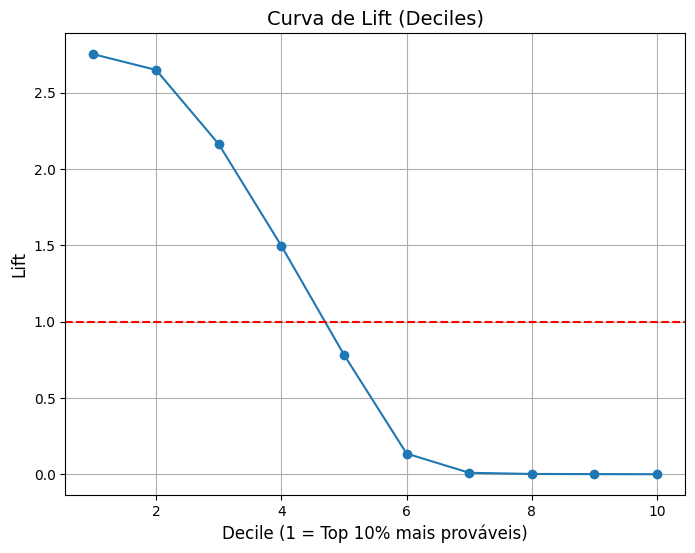

In [13]:
# 4. Obter probabilidades preditas
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# 5. Criar dataframe com labels e probabilidades
df = pd.DataFrame({"y_true": y_test, "y_proba": y_pred_proba})

# Ordenar por probabilidade decrescente
df = df.sort_values("y_proba", ascending=False).reset_index(drop=True)

# 6. Dividir em deciles (10 grupos iguais)
df["decile"] = pd.qcut(df.index, 10, labels=False)

# 7. Calcular Lift
base_rate = df["y_true"].mean()  # taxa média da base
lift_table = df.groupby("decile").apply(
    lambda x: x["y_true"].mean() / base_rate
)

# 8. Plotar curva de Lift
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), lift_table.values, marker='o')
plt.axhline(y=1, color='r', linestyle='--')  # linha do acaso
plt.title("Curva de Lift (Deciles)", fontsize=14)
plt.xlabel("Decile (1 = Top 10% mais prováveis)", fontsize=12)
plt.ylabel("Lift", fontsize=12)
plt.grid(True)
plt.show()